## Data Augmentation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
data = {
    "age" : [],
    "gender" : [],
    "race" : [],
    "date_time" : [],
    "file_name" : [],
}

directory_path = "./UTKFace/"

file_name = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
count = 0
for file in file_name:
    parts = file.split("_")
    if len(parts) != 4:
        continue
    try:
        data["age"].append(int(parts[0]))
        data["gender"].append(int(parts[1]))
        data["race"].append(int(parts[2]))
        data["date_time"].append((parts[3].split(".jpg.chip.jpg")[0]))
        data["file_name"].append(file)
        
    except ValueError:
        print(f"FILE {file} is Skipped")
        count = count + 1
        continue
        
        
df = pd.DataFrame(data)

In [3]:
df.shape

(23705, 5)

In [4]:
def categorize_age(age):
    if age <= 14:
        return "Children"
    elif age <= 24:
        return "Teenagers"
    elif age <= 35:
        return "Young Adults"
    elif age <= 59:
        return "Adults"
    else:
        return "Seniors"
    
df["age_category"] = df["age"].apply(categorize_age)    

In [5]:
age_mapping = {
    "Children" : 0,
    "Teenagers" : 1,
    "Young Adults" : 2,
    "Adults" : 3,
    "Seniors" : 4
}

race_mapping = {
    "White" : 0,
    "Black" : 1,
    "Asian" : 2,
    "Indian" : 3,
    "Others" : 4
}

gender_mapping = {
    "Male" : 0,
    "Female" : 1
}

reverse_age_mapping = {v:k for k,v in age_mapping.items()}
reverse_race_mapping = {v:k for k,v in race_mapping.items()}
reverse_gender_mapping = {v:k for k,v in gender_mapping.items()}

df["age_category"] = df["age"].apply(categorize_age)
df["age_category_encoded"] = df["age_category"].map(age_mapping)
df["race_encoded"] = df["race"].map(reverse_race_mapping)
df["gender_encoded"] = df["gender"].map(reverse_gender_mapping)  

5 => age groups
5 => race groups
2 => genders

50 combination

In [6]:
df["combined_category"] = df["age_category"] + "_" + df["race_encoded"].astype(str) + "_" + df["gender_encoded"].astype(str)

In [7]:
df.head()

,age,gender,race,date_time,file_name,age_category,age_category_encoded,race_encoded,gender_encoded,combined_category
0,100,0,0,20170112213500903,100_0_0_20170112213500903.jpg.chip.jpg,Seniors,4,White,Male,Seniors_White_Male
1,100,0,0,20170112215240346,100_0_0_20170112215240346.jpg.chip.jpg,Seniors,4,White,Male,Seniors_White_Male
2,100,1,0,20170110183726390,100_1_0_20170110183726390.jpg.chip.jpg,Seniors,4,White,Female,Seniors_White_Female
3,100,1,0,20170112213001988,100_1_0_20170112213001988.jpg.chip.jpg,Seniors,4,White,Female,Seniors_White_Female
4,100,1,0,20170112213303693,100_1_0_20170112213303693.jpg.chip.jpg,Seniors,4,White,Female,Seniors_White_Female


In [8]:
len(df.combined_category.value_counts())

50

In [9]:
df.combined_category.value_counts(normalize = True)*100 # percentage of each category in dataset

Adults_White_Male             8.373761
Young Adults_White_Male       5.762497
Young Adults_White_Female     5.163468
Young Adults_Black_Female     4.859734
Young Adults_Black_Male       4.703649
Adults_White_Female           4.399916
Seniors_White_Male            3.910567
Adults_Indian_Male            3.754482
Seniors_White_Female          3.729171
Young Adults_Asian_Female     3.383252
Children_White_Female         3.303101
Young Adults_Indian_Male      3.286227
Young Adults_Indian_Female    3.083738
Children_White_Male           3.007804
Teenagers_White_Female        2.813752
Adults_Black_Male             2.666104
Children_Asian_Male           2.155663
Adults_Black_Female           2.079730
Teenagers_White_Male          2.050200
Children_Asian_Female         1.944737
Young Adults_Asian_Male       1.906771
Teenagers_Asian_Female        1.746467
Teenagers_Indian_Female       1.615693
Teenagers_Black_Female        1.459608
Children_Indian_Female        1.252900
Young Adults_Others_Male 

In [10]:
df.reset_index(drop = True, inplace = True)

stratified_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in stratified_split.split(df, df["combined_category"]):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
    
test_df.reset_index(drop = True, inplace = True)

validation_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)
for test_index, valid_index in validation_split.split(test_df, test_df["combined_category"]):
    test_df_final = test_df.loc[test_index]
    valid_df = test_df.loc[valid_index]
    
print(f"Training : {len(train_df)}")
print(f"Test : {len(test_df_final)}")
print(f"validation : {len(valid_df)}")

Training : 18964
Test : 2370
validation : 2371


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_distribution(df, title):
    plt.figure(figsize = (8,4))
    category_counts = df["combined_category"].value_counts()
    sns.barplot(x = category_counts.index, y = category_counts.values)
    plt.xticks(rotation = 90)
    plt.ylabel("combined categories")
    plt.xlabel("Number of images")
    plt.title(title)
    plt.show()

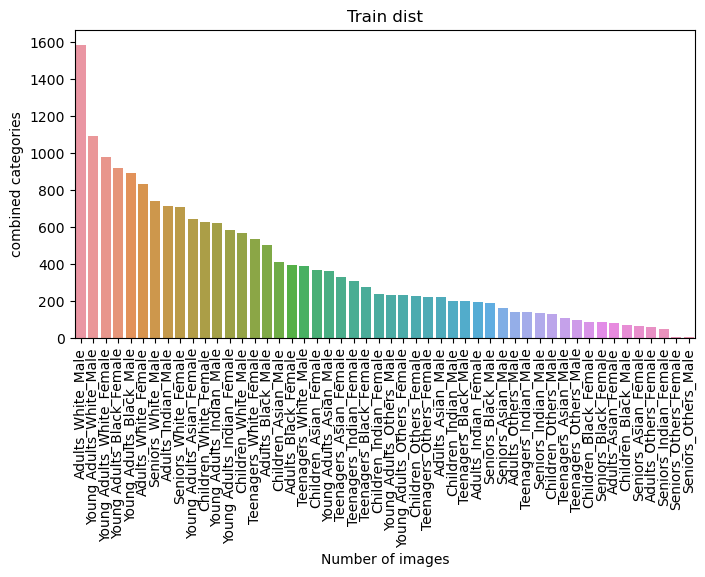

In [12]:
plot_category_distribution(train_df, "Train dist")

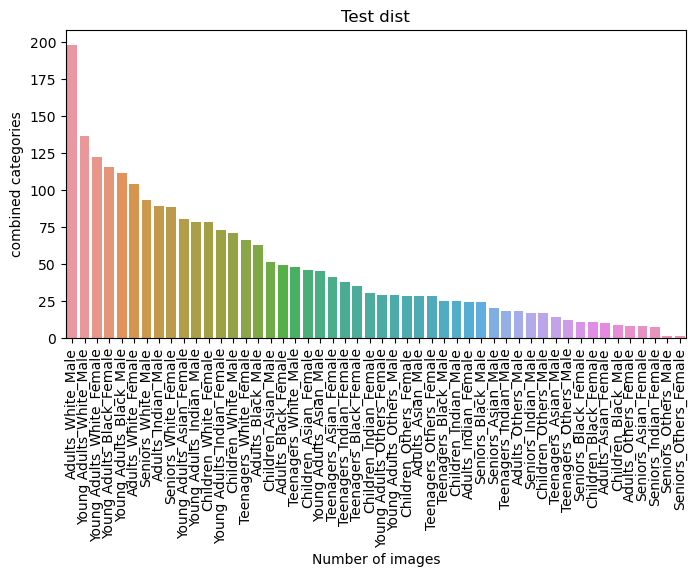

In [13]:
plot_category_distribution(test_df_final, "Test dist")

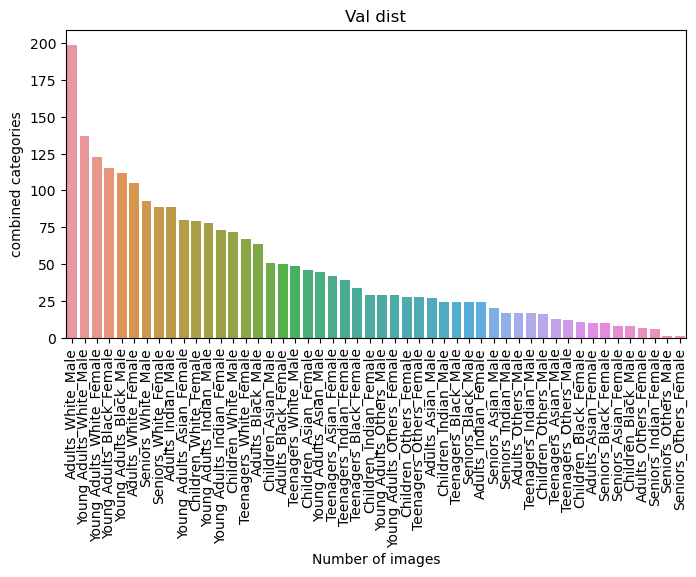

In [14]:
plot_category_distribution(valid_df, "Val dist")

In [15]:
train_df.to_csv("./UTKFace/train_split.csv", index = False)
test_df_final.to_csv("./UTKFace/test_split.csv" , index = False)
valid_df.to_csv("./UTKFace/valid_split.csv" , index = False)

In [16]:
# movinig train images to new folder name 'train' before augmentation 
import os
import shutil

#organizeing images from the UTKFace dataset into categorized directories for training 
def create_and_copy_to_category_dirs(df, source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    for index, row in df.iterrows():
        category_dir = os.path.join(target_dir, row["combined_category"])
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)
            
        source_path = os.path.join(source_dir, row["file_name"])
        target_path = os.path.join(category_dir, row["file_name"])
        
        shutil.copy(source_path, target_path)
        
source_directory_path = "./UTKFace/"
train_directory_path =  "./UTKFace/train/"

create_and_copy_to_category_dirs(train_df,source_directory_path, train_directory_path)

## performing data augmentation

In [1]:
from IPython.display import HTML
HTML('<img src="./giphy3.gif">')

In [18]:
import Augmentor

max_samples = train_df["combined_category"].value_counts().max()
    
train_images_path = "./UTKFace/train/"

def setup_augementor_for_category(category):
    
    category_path = os.path.join(train_images_path, category)
    
    p = Augmentor.Pipeline(category_path)
    
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.flip_left_right(probability = 0.5)
    p.zoom_random(probability = 0.5, percentage_area = 0.8)
    p.random_contrast(probability = 0.5, min_factor = 0.8, max_factor = 1.2)
    p.random_brightness(probability = 0.5, min_factor = 0.8, max_factor = 1.2)
    
    num_to_generate = max_samples - train_df[train_df["combined_category"] == category].shape[0]
    
    if num_to_generate > 0:
        p.sample(num_to_generate)
        
for category in train_df["combined_category"].unique():
    setup_augementor_for_category(category)

Initialised with 1588 image(s) found.
Output directory set to ./UTKFace/train/Adults_White_Male\output.Initialised with 922 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Black_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465912650>: 100%|██████████| 666/666 [00:04<00:00, 143.58 Samples/s]                  


Initialised with 712 image(s) found.
Output directory set to ./UTKFace/train/Adults_Indian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174658E5FC0>: 100%|██████████| 876/876 [00:06<00:00, 140.82 Samples/s]                  


Initialised with 707 image(s) found.
Output directory set to ./UTKFace/train/Seniors_White_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174643F3520>: 100%|██████████| 881/881 [00:06<00:00, 140.94 Samples/s]                  


Initialised with 534 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_White_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174659C8BE0>: 100%|██████████| 1054/1054 [00:07<00:00, 144.59 Samples/s]                 


Initialised with 834 image(s) found.
Output directory set to ./UTKFace/train/Adults_White_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465C5A530>: 100%|██████████| 754/754 [00:04<00:00, 156.36 Samples/s]                  


Initialised with 389 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_White_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174644B4220>: 100%|██████████| 1199/1199 [00:08<00:00, 147.21 Samples/s]                  


Initialised with 623 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Indian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465C382B0>: 100%|██████████| 965/965 [00:06<00:00, 142.40 Samples/s]                  


Initialised with 1093 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_White_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174659C8040>: 100%|██████████| 495/495 [00:03<00:00, 142.39 Samples/s]                  


Initialised with 331 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Asian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174658283D0>: 100%|██████████| 1257/1257 [00:08<00:00, 144.90 Samples/s]                  


Initialised with 277 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Black_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B1D80>: 100%|██████████| 1311/1311 [00:09<00:00, 135.49 Samples/s]                  


Initialised with 570 image(s) found.
Output directory set to ./UTKFace/train/Children_White_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BFF6A0>: 100%|██████████| 1018/1018 [00:06<00:00, 146.18 Samples/s]                  


Initialised with 234 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Others_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17464753760>: 100%|██████████| 1354/1354 [00:09<00:00, 142.66 Samples/s]                 


Initialised with 505 image(s) found.
Output directory set to ./UTKFace/train/Adults_Black_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17464491D80>: 100%|██████████| 1083/1083 [00:07<00:00, 145.93 Samples/s]                  


Initialised with 224 image(s) found.
Output directory set to ./UTKFace/train/Children_Others_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B2DA0>: 100%|██████████| 1364/1364 [00:09<00:00, 142.86 Samples/s]                  


Initialised with 88 image(s) found.
Output directory set to ./UTKFace/train/Children_Black_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465910B20>: 100%|██████████| 1500/1500 [00:10<00:00, 139.10 Samples/s]                  


Initialised with 193 image(s) found.
Output directory set to ./UTKFace/train/Adults_Indian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174658286A0>: 100%|██████████| 1395/1395 [00:09<00:00, 142.47 Samples/s]                  


Initialised with 306 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Indian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465911E70>: 100%|██████████| 1282/1282 [00:08<00:00, 142.92 Samples/s]                  


Initialised with 979 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_White_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174644A2530>: 100%|██████████| 609/609 [00:04<00:00, 144.16 Samples/s]                  


Initialised with 161 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Asian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465982290>: 100%|██████████| 1427/1427 [00:10<00:00, 139.63 Samples/s]                  


Initialised with 394 image(s) found.
Output directory set to ./UTKFace/train/Adults_Black_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174644A0C10>: 100%|██████████| 1194/1194 [00:08<00:00, 145.48 Samples/s]                  


Initialised with 626 image(s) found.
Output directory set to ./UTKFace/train/Children_White_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B0460>: 100%|██████████| 962/962 [00:06<00:00, 148.55 Samples/s]                  


Initialised with 130 image(s) found.
Output directory set to ./UTKFace/train/Children_Others_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465C7BC70>: 100%|██████████| 1458/1458 [00:10<00:00, 140.31 Samples/s]                  


Initialised with 642 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Asian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174658E72E0>: 100%|██████████| 946/946 [00:06<00:00, 145.75 Samples/s]                  


Initialised with 197 image(s) found.
Output directory set to ./UTKFace/train/Children_Indian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B1BD0>: 100%|██████████| 1391/1391 [00:09<00:00, 141.10 Samples/s]                  


Initialised with 741 image(s) found.
Output directory set to ./UTKFace/train/Seniors_White_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465C79F90>: 100%|██████████| 847/847 [00:05<00:00, 141.29 Samples/s]                  


Initialised with 190 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Black_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B0CA0>: 100%|██████████| 1398/1398 [00:09<00:00, 144.91 Samples/s]                  


Initialised with 197 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Black_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174644B5A80>: 100%|██████████| 1391/1391 [00:09<00:00, 143.07 Samples/s]                  


Initialised with 362 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Asian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465DE8DC0>: 100%|██████████| 1226/1226 [00:08<00:00, 141.40 Samples/s]                  


Initialised with 137 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Indian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BE8910>: 100%|██████████| 1451/1451 [00:10<00:00, 138.93 Samples/s]                  


Initialised with 585 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Indian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465DF5ED0>: 100%|██████████| 1003/1003 [00:06<00:00, 149.96 Samples/s]                 


Initialised with 82 image(s) found.
Output directory set to ./UTKFace/train/Adults_Asian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x1746589FC70>: 100%|██████████| 1506/1506 [00:10<00:00, 144.44 Samples/s]                  


Initialised with 409 image(s) found.
Output directory set to ./UTKFace/train/Children_Asian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BD0E80>: 100%|██████████| 1179/1179 [00:08<00:00, 141.87 Samples/s]                  


Initialised with 233 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Others_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465DEA5C0>: 100%|██████████| 1355/1355 [00:09<00:00, 142.69 Samples/s]                  


Initialised with 892 image(s) found.
Output directory set to ./UTKFace/train/Young Adults_Black_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BFF0A0>: 100%|██████████| 696/696 [00:04<00:00, 150.95 Samples/s]                  


Initialised with 369 image(s) found.
Output directory set to ./UTKFace/train/Children_Asian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B06D0>: 100%|██████████| 1219/1219 [00:08<00:00, 141.12 Samples/s]                  


Initialised with 219 image(s) found.
Output directory set to ./UTKFace/train/Adults_Asian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x1746447C6A0>: 100%|██████████| 1369/1369 [00:09<00:00, 140.18 Samples/s]                  


Initialised with 238 image(s) found.
Output directory set to ./UTKFace/train/Children_Indian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BFCE20>: 100%|██████████| 1350/1350 [00:09<00:00, 142.88 Samples/s]                 


Initialised with 140 image(s) found.
Output directory set to ./UTKFace/train/Adults_Others_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465DF6E60>: 100%|██████████| 1448/1448 [00:10<00:00, 142.76 Samples/s]                  


Initialised with 221 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Others_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174644A1F90>: 100%|██████████| 1367/1367 [00:09<00:00, 139.42 Samples/s]                  


Initialised with 97 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Others_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BEA0B0>: 100%|██████████| 1491/1491 [00:10<00:00, 143.14 Samples/s]                  


Initialised with 60 image(s) found.
Output directory set to ./UTKFace/train/Adults_Others_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465872980>: 100%|██████████| 1528/1528 [00:11<00:00, 138.43 Samples/s]                  


Initialised with 7 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Others_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465BA70A0>: 100%|██████████| 1581/1581 [00:11<00:00, 138.84 Samples/s]                  


Initialised with 140 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Indian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x1746589F580>: 100%|██████████| 1448/1448 [00:10<00:00, 140.58 Samples/s]                  


Initialised with 86 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Black_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B14B0>: 100%|██████████| 1502/1502 [00:10<00:00, 136.77 Samples/s]                  


Initialised with 70 image(s) found.
Output directory set to ./UTKFace/train/Children_Black_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17465DE8940>: 100%|██████████| 1518/1518 [00:10<00:00, 143.02 Samples/s]                  


Initialised with 64 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Asian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x1746589E500>: 100%|██████████| 1524/1524 [00:10<00:00, 142.42 Samples/s]                  


Initialised with 110 image(s) found.
Output directory set to ./UTKFace/train/Teenagers_Asian_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x174657B2170>: 100%|██████████| 1478/1478 [00:10<00:00, 138.27 Samples/s]                  


Initialised with 7 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Others_Male\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17464697820>: 100%|██████████| 1581/1581 [00:11<00:00, 138.85 Samples/s]                  


Initialised with 49 image(s) found.
Output directory set to ./UTKFace/train/Seniors_Indian_Female\output.

Processing <PIL.Image.Image image mode=RGB size=200x200 at 0x17464491480>: 100%|██████████| 1539/1539 [00:11<00:00, 135.16 Samples/s]                  


train => {category} => {non augmented images} + {output/{augmented images}}

In [20]:
def create_df_for_augmented_images(directory):
    augmented_data = {
        "age" : [],
        "gender" : [],
        "race" : [],
        "file_name" : [],
        "age_category" : [],
        "age_category_encoded" : [],
        "race_encoded" : [],
        "gender_encoded" : [],
        "combined_category" : []
    }
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        output_path = os.path.join(category_path, "output")
        if os.path.isdir(output_path):
            for file_name in os.listdir(output_path):
                file_path = os.path.join(output_path, file_name)
                if os.path.isfile(file_path):
                    try:
                        parts = file_name.split("_")
                        original_index = parts.index("original")
                        age = int(parts[original_index + 1])
                        gender_index = int(parts[original_index + 2])
                        race_index = int(parts[original_index + 3])
                        
                        augmented_data["age"].append(age)
                        augmented_data["gender"].append(reverse_gender_mapping[gender_index])
                        augmented_data["race"].append(reverse_race_mapping[race_index])
                        augmented_data["file_name"].append(file_name)
                        age_category = categorize_age(age)
                        augmented_data["age_category"].append(age_category)
                        augmented_data["age_category_encoded"].append(age_mapping[age_category])
                        augmented_data["race_encoded"].append(race_mapping[reverse_race_mapping[race_index]])
                        augmented_data["gender_encoded"].append(gender_mapping[reverse_gender_mapping[gender_index]])
                        augmented_data["combined_category"].append(category)
                    except (ValueError, IndexError, KeyError):
                        print(f"{file_name} error")
                        
    return pd.DataFrame(augmented_data)

augmented_train_df = create_df_for_augmented_images(train_images_path)
combined_train_df = pd.concat([train_df, augmented_train_df]).reset_index(drop = True)

In [21]:
combined_train_df.isnull().sum()

age                         0
gender                      0
race                        0
date_time               60436
file_name                   0
age_category                0
age_category_encoded        0
race_encoded                0
gender_encoded              0
combined_category           0
dtype: int64

In [22]:
combined_train_df.head()

,age,gender,race,date_time,file_name,age_category,age_category_encoded,race_encoded,gender_encoded,combined_category
0,41,0,0,20170104165442057,41_0_0_20170104165442057.jpg.chip.jpg,Adults,3,White,Male,Adults_White_Male
1,35,1,1,20170112213036050,35_1_1_20170112213036050.jpg.chip.jpg,Young Adults,2,Black,Female,Young Adults_Black_Female
2,52,0,0,20170111203528972,52_0_0_20170111203528972.jpg.chip.jpg,Adults,3,White,Male,Adults_White_Male
3,37,0,3,20170117183422120,37_0_3_20170117183422120.jpg.chip.jpg,Adults,3,Indian,Male,Adults_Indian_Male
4,85,1,0,20170110181946121,85_1_0_20170110181946121.jpg.chip.jpg,Seniors,4,White,Female,Seniors_White_Female


In [23]:
len(combined_train_df.combined_category.value_counts())

50

In [24]:
combined_train_df.combined_category.value_counts(normalize = True)*100

Adults_White_Male             2.0
Children_Indian_Female        2.0
Teenagers_Black_Male          2.0
Young Adults_Asian_Male       2.0
Seniors_Indian_Male           2.0
Young Adults_Indian_Female    2.0
Adults_Asian_Female           2.0
Children_Asian_Male           2.0
Young Adults_Others_Female    2.0
Young Adults_Black_Male       2.0
Children_Asian_Female         2.0
Adults_Asian_Male             2.0
Adults_Others_Male            2.0
Young Adults_Black_Female     2.0
Teenagers_Others_Female       2.0
Teenagers_Others_Male         2.0
Adults_Others_Female          2.0
Seniors_Others_Female         2.0
Teenagers_Indian_Male         2.0
Seniors_Black_Female          2.0
Children_Black_Male           2.0
Seniors_Asian_Female          2.0
Teenagers_Asian_Male          2.0
Seniors_Others_Male           2.0
Seniors_Black_Male            2.0
Seniors_White_Male            2.0
Children_Indian_Male          2.0
Young Adults_Asian_Female     2.0
Adults_Indian_Male            2.0
Seniors_White_

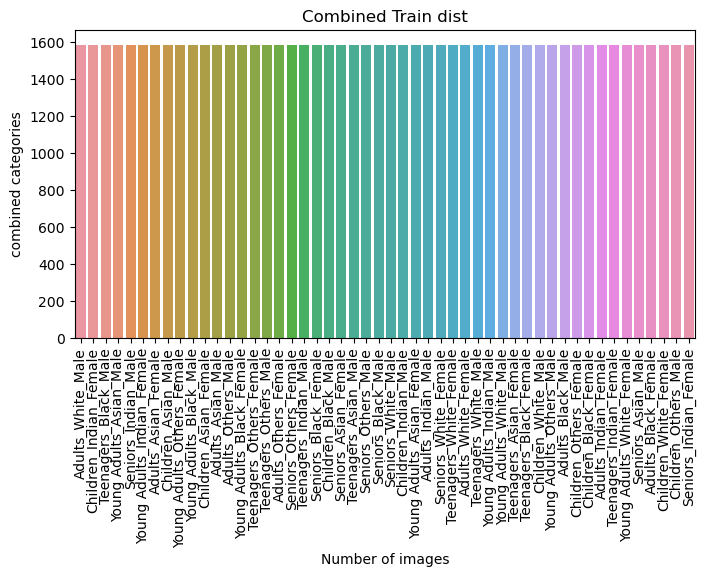

In [25]:
plot_category_distribution(combined_train_df, "Combined Train dist")

In [26]:
augmented_train_df.to_csv("./UTKFace/augmented_train_split.csv", index = False)
combined_train_df.to_csv("./UTKFace/combined_train_split.csv", index = False)